# GPU Accelerated Elastic Deep Learning Service in Cloud Pak for Data

#### Notebook created by Kelvin Lui, Xue Yin Zhuang, Xue Zhou Yuan (January 2021)

Watson Machine Learning Accelerator in Cloud Pak for Data offers GPU Accelerated Elastic Deep Learning service.   This service enables multiple data scientists to accelerate deep learning model training across multiple GPUs and server, share GPUs in a dynamic fashion,  and drives data scientist productivity and overall GPU utilization.

In this notebook, you will learn how to scale PyTorch model with multiple GPUs with GPU Accelerated Elastic Deep Learning service, monitor the running job, and debug any issues seen.

This notebook uses Watson Machine learning Accelerator 1.2.3 with Cloud Pak for Data 3.5.


### Contents

- [The big picture](#The-big-picture)
- [Changes to your code](#Changes-to-your-code)
- [Set up API end point and log on](#Set-up-API-end-point-and-log-on)
- [Submit job via API](#Submit-job-via-API)
- [Monitor running job](#Monitor-running-job)
- [Retrieve output and saved models](#Retrieve-output-and-saved-models)
  - [Output - Retrieve training output](#Output:--Retrieve-Training-Metric)
  - [Save Models](#Save-Model)
- [Debugging any issues](#Debugging-any-issues)
- [Further information and useful links](#Further-information-and-useful-links)
- [Appendix](#Appendix)




## The big picture
[Back to top](#Contents)

This notebook details the process of taking your PyTorch model and making the changes required to train the model using [IBM Watson Machine Learning GPU Accelerated Elastic Deep Learning service](https://developer.ibm.com/series/learning-path-get-started-with-watson-machine-learning-accelerator/) (WML Accelerator) 


The image below shows the various elements required to use Elastic Deep Learning Serivce. In this notebook we will step through each of these elements in more detail. Through this process you will offload your code to a WML Accelerator cluster, monitor the running job, retrieve the output and debug any issues seen. A [static version](https://github.com/IBM/wmla-assets/raw/master/WMLA-learning-journey/shared-images/5_running_job.png) is also available.

![overall](https://github.com/IBM/wmla-assets/raw/master/WMLA-learning-journey/shared-images/5_running_job.gif)

## Changes to your code
[Back to top](#Contents)

In this section we will take PyTorch model and make the relevant changes required. An overview of these changes can be seen in the diagram below. A [static version](https://github.com/IBM/wmla-assets/raw/master/WMLA-learning-journey/shared-images/2_code_adaptations.png) is also available.

![code](https://github.com/IBM/wmla-assets/raw/master/WMLA-learning-journey/shared-images/2_code_adaptations.gif)



The key changes to your code in order to use elastic distributed training are the following:
- Importing libraries and setting up environment variables
- Data loading function for elastic distributed training 
- Extract parameters for training
- Replace training and testing loops with the loop equivalents for elastic distributed training

For the purpose of this tutorial we train RestNet50 model with Elastic Distributed Training (EDT).

See the blog associated with this notebook with more detailed explanation of the above changes.
https://developer.ibm.com/articles/elastic-distributed-training-edt-in-watson-machine-learning-accelerator/


Your modified code should be made available in a directory which also contains the elastic distributed training helper scripts: `edtcallback.py`, `emetrics.py` and `elog.py`. See more information about the Elastic Distributed Training API in [IBM Documentation](https://www.ibm.com/docs/en/wmla/1.2.3?topic=learning-elastic-distributed-training).


In [1]:
import os
model_dir = f'/tmp/resnet-wmla' 
model_main = f'elastic-main.py'
model_callback = f'edtcallback.py'
model_elog = f'elog.py'

os.makedirs(model_dir, exist_ok=True)

Resnet50 model: elastic-main.py. This is the main file that is required by the elastic distributed training engine. It acts as the program main entrance.




In [2]:
%%writefile {model_dir}/{model_main}
#!/usr/bin/env python

from __future__ import print_function
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from callbacks import Callback
from fabric_model import FabricModel
from edtcallback import EDTLoggerCallback
import torch
import os


## Define model and extract training parameters
def get_max_worker():
    import argparse
    parser = argparse.ArgumentParser(description='EDT Example')
    parser.add_argument('--numWorker', type=int, default='16', help='input the max number ')
    parser.add_argument('--gpuPerWorker', type=int, default='1', help='input the path of initial weight file')
    args, _ = parser.parse_known_args()
    num_worker = args.numWorker * args.gpuPerWorker
    return num_worker

BATCH_SIZE_PER_DEVICE = 64
NUM_EPOCHS = 2
MAX_NUM_WORKERS = get_max_worker()

START_LEARNING_RATE = 0.4
LR_STEP_SIZE = 30
LR_GAMMA = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4

## Define dataset location 
DATA_DIR = os.getenv("DATA_DIR")
if DATA_DIR is None:
    DATA_DIR = '/tmp'
print("DATA_DIR: " + DATA_DIR)
TRAIN_DATA = DATA_DIR + "/cifar10"
TEST_DATA = DATA_DIR + "/cifar10"


## <Xue Yin>  Documentation of Callback function
class LRScheduleCallback(Callback):
    def __init__(self, step_size, gamma):
        super(LRScheduleCallback, self).__init__()
        self.step_size = step_size
        self.gamma = gamma

    def on_epoch_begin(self, epoch):
        if (epoch != 0) and (epoch % self.step_size == 0):
            for param_group in self.params['optimizer'].param_groups:
                param_group['lr'] *= self.gamma

        print("LRScheduleCallback epoch={}, learning_rate={}".format(epoch,
              self.params['optimizer'].param_groups[0]['lr']))

## Data loading function for EDT
def getDatasets():
    transform_train = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    return (torchvision.datasets.CIFAR10(root=TRAIN_DATA, train=True, download=True, transform=transform_train),
            torchvision.datasets.CIFAR10(root=TEST_DATA, train=False, download=True, transform=transform_test))

def custom_train(model, data, eva, train_loader, fn_args):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt = model.get_optimizer()
    opt.zero_grad()
    outputs = model(inputs)
    cri = model.get_loss_function()
    loss = cri(outputs, labels)
    loss.backward()
    acc = eva(outputs, labels)
    return acc, loss

def custom_test(model, test_iter, fn_args):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cri = model.get_loss_function()
    valid_loss = 0.0
    counter = 0
    for(inputs, labels) in test_iter:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs)
        loss = cri(output, labels)
        valid_loss += loss.item()
        counter += 1
    valid_loss /= counter
    return valid_loss

def main(model_type):
    print('==> Building model..' + str(model_type))
    model = models.__dict__[model_type]()
    optimizer = optim.SGD(model.parameters(), lr=START_LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    loss_function = F.cross_entropy
    
#     edt_m = FabricModel(model, getDatasets, loss_function, optimizer, enable_onnx=True, fn_step_train=custom_train, 
#                         fn_test=custom_test, user_callback=[LRScheduleCallback(LR_STEP_SIZE, LR_GAMMA)], driver_logger=EDTLoggerCallback())
    edt_m = FabricModel(model, getDatasets, loss_function, optimizer, enable_onnx=True, fn_step_train=custom_train, 
                        fn_test=custom_test, driver_logger=EDTLoggerCallback())
    print('==> epochs:' + str(NUM_EPOCHS) + ', batchsize:' + str(BATCH_SIZE_PER_DEVICE) + ', engines_number:' + str(MAX_NUM_WORKERS))
    edt_m.train(NUM_EPOCHS, BATCH_SIZE_PER_DEVICE, MAX_NUM_WORKERS, num_dataloader_threads=4, validation_freq=10, checkpoint_freq=0)

if __name__ == '__main__':
    main("resnet50")


Overwriting /tmp/resnet-wmla/elastic-main.py


### EDT helper scripts: edtcallback.py
The edtcallback.py scripts counts model loss and accuracy and logs them to the driver log.

In [3]:
%%writefile {model_dir}/{model_callback}
#! /usr/bin/env python

from __future__ import print_function

import sys
import os

from callbacks import LoggerCallback
from emetrics import EMetrics
from elog import ELog

'''
    EDTLoggerCallback class define LoggerCallback to trigger Elog.
'''

class EDTLoggerCallback(LoggerCallback):
    def __init__(self):
        self.gs =0

    def log_train_metrics(self, loss, acc, completed_batch,  worker=0):
        acc = acc/100.0
        self.gs += 1
        with EMetrics.open() as em:
            em.record(EMetrics.TEST_GROUP,completed_batch,{'loss': loss, 'accuracy': acc})
        with ELog.open() as log:
            log.recordTrain("Train", completed_batch, self.gs, loss, acc, worker)

    def log_test_metrics(self, loss, acc, completed_batch, worker=0):
        acc = acc/100.0
        with ELog.open() as log:
            log.recordTest("Test", loss, acc, worker)

Overwriting /tmp/resnet-wmla/edtcallback.py


### EDT helper scripts: elog.py.
The elog.py script defines the path and content of the training and test log.


In [4]:
%%writefile {model_dir}/{model_elog}
import time
import os

'''
    ELog class define the path and content of train and test log.
'''

class ELog(object):

    def __init__(self,subId,f):
        if "TRAINING_ID" in os.environ:
            self.trainingId = os.environ["TRAINING_ID"]
        elif "DLI_EXECID" in os.environ:
            self.trainingId = os.environ["DLI_EXECID"]
        else:
            self.trainingId = ""
        self.subId = subId
        self.f = f

    def __enter__(self):
        return self

    def __exit__(self, type, value, tb):
        self.close()

    @staticmethod
    def open(subId=None):
        if "LOG_DIR" in os.environ:
            folder = os.environ["LOG_DIR"]
        elif "JOB_STATE_DIR" in os.environ:
            folder = os.path.join(os.environ["JOB_STATE_DIR"],"logs")
        else:
            folder = "/tmp"

        if subId is not None:
            folder = os.path.join(folder, subId)

        if not os.path.exists(folder):
            os.makedirs(folder)

        f = open(os.path.join(folder, "stdout"), "a")
        return ELog(subId,f)

    def recordText(self,text):
        timestr = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        timestr = "["+ timestr + "]"
        if self.f:
            self.f.write(timestr + " " + text + "\n")
            self.f.flush()

    def recordTrain(self,title,iteration,global_steps,loss,accuracy,worker):
        text = title
        text = text + ",	Timestamp: " + str(int(round(time.time() * 1000)))
        text = text + ",	Global steps: " + str(global_steps)
        text = text + ",	Iteration: " + str(iteration)
        text = text + ",	Loss: " + str(float('%.5f' % loss) )
        text = text + ",	Accuracy: " + str(float('%.5f' % accuracy) )
        self.recordText(text)

    def recordTest(self,title,loss,accuracy,worker):
        text = title
        text = text + ",	Timestamp: " + str(int(round(time.time() * 1000)))
        text = text + ",	Loss: " + str(float('%.5f' % loss) )
        text = text + ",	Accuracy: " + str(float('%.5f' % accuracy) )
        self.recordText(text)

    def close(self):
        if self.f:
            self.f.close()

Overwriting /tmp/resnet-wmla/elog.py


In [15]:
### Package model files for training
import requests, json
import pandas as pd
import datetime
# from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
# plt.rcParams['figure.figsize'] = [24, 8.0]
#import seaborn as sns

pd.set_option('display.max_columns', 999)
pd.set_option('max_colwidth', 300)

import tarfile
import tempfile
import os
#Package the updated model files into a tar file ending with `.modelDir.tar`

In [25]:
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))


MODEL_DIR_SUFFIX = ".modelDir.tar"
tempFile = tempfile.mktemp(MODEL_DIR_SUFFIX)
make_tarfile(tempFile, model_dir)

print(" tempFile: " + tempFile)
files = {'file': open(tempFile, 'rb')}

 tempFile: /var/folders/5n/bsvbwc4x2pv391y0zqg1b22c0000gn/T/tmpzy2uun2u.modelDir.tar


## Set up API endpoint and log on
[Back to top](#Contents)

In this section we set up the API endpoint which will be used in this notebook.

1. Source the environment:

$EGO_TOP is the installation directory.  The default value is /opt/ibm/spectrumcomputing. 

```
. $EGO_TOP/profile.platform
```
2. Log in to the WML Accelerator clsuter:

```
egosh user logon -u <wmla_user>
Logged on successfully

```

3. Retrieve the Conductor Rest API port:

```
egosh client view |grep -A 3 ASCD_REST_BASE_URL_1
CLIENT NAME: ASCD_REST_BASE_URL_1
DESCRIPTION: http://<WMLA-server>:8280/platform/rest/

```

4.  Retrieve the Deep Learning Impact (DLI) Rest API port:

```
egosh client view |grep -A 3 DLPD_REST_BASE_URL_1
CLIENT NAME: DLPD_REST_BASE_URL_1
DESCRIPTION: http://<WMLA-server>:9280/platform/rest/

```

Note that the port numbers in your URL will depend on whether SSL has been enabled or not.



## Submit job via API
[Back to top](#Contents)

Now we need to structure our API job submission. There are various elements to this process as seen in the diagram below. Note that **this** Jupyter notebook is the one referred to below. A [static version](https://github.com/IBM/wmla-assets/raw/master/WMLA-learning-journey/shared-images/4_api_setup.png) is also available.

![code](https://github.com/IBM/wmla-assets/raw/master/WMLA-learning-journey/shared-images/4_api_setup.gif)


The following sections use the Watson ML Accelerator API to complete the various tasks required. 
We have provided examples of a number of tasks but for more information, refer to the documentation for additional details at to see more details and sample output. 

- https://www.ibm.com/docs/en/wmla/1.2.3?topic=api-deeplearning
- https://www.ibm.com/docs/en/spectrum-conductor/2.5.0?topic=reference-restful-api-references

In [26]:
import requests, json
import pandas as pd
import datetime
# from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
# plt.rcParams['figure.figsize'] = [24, 8.0]
#import seaborn as sns

pd.set_option('display.max_columns', 999)
pd.set_option('max_colwidth', 300)

import tarfile
import tempfile
import os


In [27]:
# Environment details:

protocol = 'https'

#master_host = 'colonia05.platform'
#master_host = 'baremetal03.ibm-ibm-platform-lab-team-test-account.cloud'
master_host = 'ma1gpu11.ma.platformlab.ibm.com'

dli_rest_port = '11573'
sc_rest_port = '28433'


sc_rest_url =  protocol+'://'+master_host+':'+sc_rest_port+'/platform/rest/conductor/v1'
dl_rest_url = protocol+'://'+master_host+':'+dli_rest_port+'/platform/rest/deeplearning/v1'

print (sc_rest_url)
print (dl_rest_url)
# User login details

wmla_user = 'Admin'
wmla_pwd = 'Admin'


myauth = (wmla_user, wmla_pwd)

# Spark instance group details
#sig_name = '**** ADD HERE ****'
#sigName = 'ClaimsDamageDetection-IG'
sigName = 'elasticsig'

# REST call variables
headers = {'Accept': 'application/json'}


#startTuneUrl='%s://%s:%s/platform/rest/deeplearning/v1/hypersearch' % (protocol, master_host, dli_rest_port)
#sc_rest_url ='%s://%s:%d/platform/rest/conductor/v1' % (protocol, hostname, conductorport)

req = requests.Session()

https://ma1gpu11.ma.platformlab.ibm.com:28433/platform/rest/conductor/v1
https://ma1gpu11.ma.platformlab.ibm.com:11573/platform/rest/deeplearning/v1


### Log on


Obtain login session tokens to be used for session authentication within the RESTful API. Tokens are valid for 8 hours.

In [28]:
r = requests.get(sc_rest_url+'/auth/logon', verify=False, auth=myauth, headers=headers) 

if r.ok:
    print ('\nLogon succeeded')
    
else: 
    print('\nLogon failed with code={}, {}'. format(r.status_code, r.content))


Logon succeeded


/Users/kelvinlui/opt/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


### Check deep learning framework details

Check what framework plugins are available and see example execution commands.  In this demonstration we will use **edtPyTorch**.

In [29]:
r = requests.get(dl_rest_url+'/execs/frameworks', auth=myauth, headers=headers, verify=False).json()
# Using the raw json, easier to see the examples given
print(json.dumps(r, indent=4))

[
    {
        "name": "edtTensorflow",
        "description": "",
        "desc": [
            "Tensorflow - IBM Elastic Distributed Training (EDT)",
            "Examples:",
            "$ python dlicmd.py --exec-start edtTensorflow <connection-options> --ig <ig> --cs-datastore-meta type=fs,data_path=mnist --model-main mnist.py"
        ],
        "frameworkVersion": "2.4.1"
    },
    {
        "name": "PyTorch",
        "description": "",
        "desc": [
            "PyTorch",
            "Examples:",
            "$ python dlicmd.py --exec-start PyTorch <connection-options> --ig <ig> --cs-datastore-meta type=fs,data_path=mnist --model-main mnist.py"
        ],
        "frameworkVersion": "1.7.1"
    },
    {
        "name": "disttensorflow",
        "description": "",
        "desc": [
            "Distributed TensorFlow",
            "Instead of passing parameters such as ps_hosts, worker_hosts, specify --numPs",
            "as in example below. Parameter servers (ps) and wor

/Users/kelvinlui/opt/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


### Arguments for API call
Equivalent of flags used if running command directly on WML Accelerator CLI, including:


In [30]:
framework_name = 'edtPyTorch' # DL Framework to use, from list given above
dataset_location = 'pytorch-mnist' # relative path of your data set under $DLI_DATA_FS
local_dir_containing_your_code = 'resnet-wmla'
number_of_GPU = '2' # number of GPUs for elastic distribution
name_of_your_code_file = 'elastic-main.py' # Main model file as opened locally above


args = '--exec-start {} \
        --cs-datastore-meta type=fs,data_path={} \
        --model-dir {} \
        --edt-options maxWorkers={} \
        --model-main {} \
        '.format(framework_name, dataset_location, local_dir_containing_your_code, number_of_GPU, name_of_your_code_file)

print ("args: " + args)

args: --exec-start edtPyTorch         --cs-datastore-meta type=fs,data_path=pytorch-mnist         --model-dir resnet-wmla         --edt-options maxWorkers=2         --model-main elastic-main.py         


### Submit Job

In [31]:
r = requests.post(dl_rest_url+'/execs?sigName='+sigName+'&args='+args, files=files,
                  auth=myauth, headers=headers, verify=False)

if r.ok:
    exec_id = r.json()['id']
    sig_id = r.json()['sigId']
    driver_id = r.json()['submissionId']
    print ('\nModel submitted successfully \Driver ID: {}'.format(driver_id))
    print ('Exec ID: {}'.format(exec_id))
    print ('SIG ID: {}'.format(sig_id))
else: 
    print('\nModel submission failed with code={}, {}'. format(r.status_code, r.content))

/Users/kelvinlui/opt/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)



Model submitted successfully \Driver ID: driver-20210304172400-0008-82fb7400-e86e-417d-8ab3-30b2cbe07287
Exec ID: Admin-2518647360655711-224680126
SIG ID: a8ec6f8f-224f-4584-8b57-df97955fb657


## Monitor running job
[Back to top](#Contents)

Once the job is submitted successfully we can monitor the running job. 



In [24]:
# Check status of all RUNNING jobs in SIG (rerun cell to refresh)



monitor = []
monitor_output = []

r = requests.get(sc_rest_url+'/instances/'+sig_id+'/applications?state=RUNNING', 
                auth=myauth, headers=headers, verify=False).json()


       
if (len(r) == 0):
    print ('No jobs running')
    
else:
    
    # Filter out the relevant information
    monitor.append([(
        job['driver']['id'],
        job['driver']['state'],
        job['apprunduration'],
        job['gpuslots'],
        job['gpumemused']['total'],
        job['gpudevutil']['total'],
    ) for job in r])

    monitor_output = pd.DataFrame([item for monitor in monitor for item in monitor])
    monitor_output.columns = [
        'Driver ID', 
        'State', 
        'Run duration (mins)',
        'GPU slots',
        'Total GPU memory used',
        'Total GPU utilsation (%) ',
    ]
    
    for job in r:
        executors = job['executors']
        

monitor_output

/Users/kelvinlui/opt/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


,Driver ID,State,Run duration (mins),GPU slots,Total GPU memory used,Total GPU utilsation (%)
0,driver-20210304172015-0007-b2ff28b2-1bca-4f49-a505-f9048e77b417,RUNNING,3.19625,2,15618,166.0


## Retrieve output and saved models
[Back to top](#Contents)

After the job completes then we can retrieve the output, logs and saved models. 



### Output:  Retrieve Training Metric

<span style='color:deeppink'>**TODO:** **Junfeng/Xue Zhou/Shan Gao, Please debug the empty returning string.
    
</span>

In [33]:
r = requests.get(dl_rest_url+'/execs/'+exec_id+'/log', auth=myauth, headers=headers, verify=False).json()





from io import StringIO

cols = ['timestamp','global_steps','iteration','loss','accuracy']
final_data = pd.read_csv(StringIO(r.replace(':',',')), 
                 usecols=[4,6,8,10,12], 
                 names=cols)
final_data['timestamp2'] = final_data.timestamp.apply(pd.to_datetime, unit='ms')
final_data.head(10)

/Users/kelvinlui/opt/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


,timestamp,global_steps,iteration,loss,accuracy,timestamp2
0,1614896710223,1,2,0.11528,0.0,2021-03-04 22:25:10.223
1,1614896710429,2,3,0.11385,0.0,2021-03-04 22:25:10.429
2,1614896710633,3,4,0.11369,0.0,2021-03-04 22:25:10.633
3,1614896710835,4,5,0.11350,0.0,2021-03-04 22:25:10.835
4,1614896711039,5,6,0.11371,0.0,2021-03-04 22:25:11.039
5,1614896711245,6,7,0.11431,0.0,2021-03-04 22:25:11.245
6,1614896711448,7,8,0.11437,0.0,2021-03-04 22:25:11.448
7,1614896711653,8,9,0.11424,0.0,2021-03-04 22:25:11.653
8,1614896711857,9,10,0.11422,0.0,2021-03-04 22:25:11.857
9,1614896712061,10,11,0.11409,0.0,2021-03-04 22:25:12.061


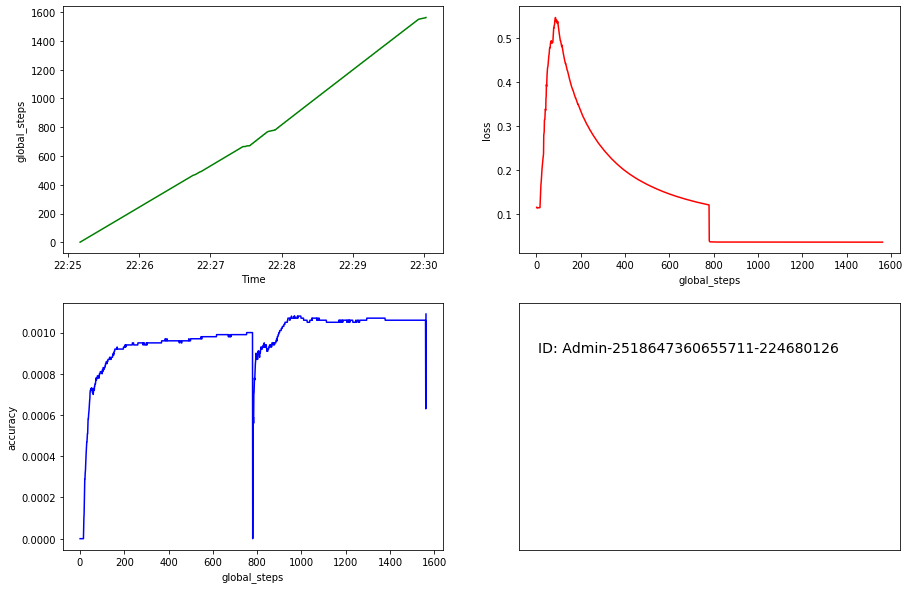

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
# plt.rcParams['figure.figsize'] = [24, 8.0]
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize = (15,10))


sns.lineplot(final_data.timestamp2,final_data.global_steps, color="g", ax=axes[0,0])
axes[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[0,0].set_xlabel("Time")

sns.lineplot(final_data.global_steps,final_data.loss, color="r", ax=axes[0,1])
sns.lineplot(final_data.global_steps,final_data.accuracy, color="b", ax=axes[1,0])

axes[1,1].axes.get_xaxis().set_visible(False)
axes[1,1].axes.get_yaxis().set_visible(False)
axes[1,1].text(0.05, 0.8, 'ID: '+exec_id, size=14)
#axes[1,1].text(0.05, 0.65, 'SIG: '+sig_name, size=14)
#axes[1,1].text(0.05, 0.55, 'Status: '+status, size=14)

plt.show()

### Save Model




In [52]:
# Get model from training job - downloads zip file (with progress bar) of saved model to directory local to this notebook
# (note that you need to save model in your code using the environment variable for location)

import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)


# r = requests.get(dl_rest_url+'/execs/'+exec_id+'/result', auth=myauth, stream=True, headers=headers, verify=False)

# total_size = int(r.headers.get('Content-Disposition').split('size=')[1])
# block_size = 1024 #1 Kibibyte
# t=tqdm(total=total_size, unit='iB', unit_scale=True)

# with open('model.zip', 'wb') as f:
#     for data in r.iter_content(block_size):
#         t.update(len(data))
#         f.write(data)
# t.close()

def download_trained_model(exec_id) :

    from IPython.display import display, FileLink

    # save result file
   # commonHeaders3={'accept': 'application/octet-stream', 'X-Auth-Token': access_token}
    headers={'Accept': 'application/octet-stream'}
    execURL = dl_rest_url  +'/execs/'+ exec_id + '/result'
    res = req.get(execURL, headers=headers, verify=False, auth=myauth)
    print (execURL)

    tmpfile =  model_dir + '/' + exec_id +'.zip'
    print ('Save model: ', tmpfile )
    with open(tmpfile,'wb') as f:
        f.write(res.content)
        f.close()
        
download_trained_model(exec_id)

https://ma1gpu11.ma.platformlab.ibm.com:11573/platform/rest/deeplearning/v1/execs/Admin-2518647360655711-224680126/result
Save model:  /tmp/resnet-wmla/Admin-2518647360655711-224680126.zip


## Debugging any issues
[Back to top](#Contents)

In the case where you have issues during the process detailed above, there are a number of detailed logs that you can view to understand what is happening on the WML Accelerator cluster.

WML Accelerator leverages Spark architecture for distributing Maching Learning and Deep Learning jobs.  In Spark,  when an item of processing has to be done, there is a “driver” process that is in charge of taking the user’s code and converting it into a set of multiple tasks. There are also “executor” processes, each operating on a separate node in the cluster, that are in charge of running the tasks, as delegated by the driver.

You can monitor ML/DL application activity,  performance and resource usage in Driver Log & Executor Log.
- Driver Log captures issues related to dependencies and environment variable,  for example,  missing dataset or invalid execution parameter flags.
- Executor Log records ML/DL training process. 



### Retrieve Training Driver Stdout Log


<span style='color:deeppink'>**TODO:** Xue Yin/Xue Zhou, Please debug the empty returning string.
    
</span>

In [59]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

retrieve_stdout_url =  dl_rest_url + '/execs/'+exec_id+'/log?logType=' + 'outlog'
print ("retrieve_stdout_url: " + str(retrieve_stdout_url))
res = requests.get(retrieve_stdout_url, auth=myauth, headers={'Accept': 'application/json'}, verify=False)

pp.pprint(res.json())


retrieve_stdout_url: https://ma1gpu11.ma.platformlab.ibm.com:11573/platform/rest/deeplearning/v1/execs/Admin-2518647360655711-224680126/log?logType=outlog
('[2021-03-04 17:25:10] Train,\tTimestamp: 1614896710223,\tGlobal steps: 1,\t'
 'Iteration: 2,\tLoss: 0.11528,\tAccuracy: 0.0\n'
 '[2021-03-04 17:25:10] Train,\tTimestamp: 1614896710429,\tGlobal steps: 2,\t'
 'Iteration: 3,\tLoss: 0.11385,\tAccuracy: 0.0\n'
 '[2021-03-04 17:25:10] Train,\tTimestamp: 1614896710633,\tGlobal steps: 3,\t'
 'Iteration: 4,\tLoss: 0.11369,\tAccuracy: 0.0\n'
 '[2021-03-04 17:25:10] Train,\tTimestamp: 1614896710835,\tGlobal steps: 4,\t'
 'Iteration: 5,\tLoss: 0.1135,\tAccuracy: 0.0\n'
 '[2021-03-04 17:25:11] Train,\tTimestamp: 1614896711039,\tGlobal steps: 5,\t'
 'Iteration: 6,\tLoss: 0.11371,\tAccuracy: 0.0\n'
 '[2021-03-04 17:25:11] Train,\tTimestamp: 1614896711245,\tGlobal steps: 6,\t'
 'Iteration: 7,\tLoss: 0.11431,\tAccuracy: 0.0\n'
 '[2021-03-04 17:25:11] Train,\tTimestamp: 1614896711448,\tGlobal steps:

 '[2021-03-04 17:28:15] Train,\tTimestamp: 1614896895325,\tGlobal steps: 914,\t'
 'Iteration: 135,\tLoss: 0.03618,\tAccuracy: 0.00103\n'
 '[2021-03-04 17:28:15] Train,\tTimestamp: 1614896895528,\tGlobal steps: 915,\t'
 'Iteration: 136,\tLoss: 0.03618,\tAccuracy: 0.00103\n'
 '[2021-03-04 17:28:15] Train,\tTimestamp: 1614896895653,\tGlobal steps: 916,\t'
 'Iteration: 137,\tLoss: 0.03618,\tAccuracy: 0.00103\n'
 '[2021-03-04 17:28:15] Train,\tTimestamp: 1614896895730,\tGlobal steps: 917,\t'
 'Iteration: 138,\tLoss: 0.03618,\tAccuracy: 0.00103\n'
 '[2021-03-04 17:28:15] Train,\tTimestamp: 1614896895932,\tGlobal steps: 918,\t'
 'Iteration: 139,\tLoss: 0.03618,\tAccuracy: 0.00103\n'
 '[2021-03-04 17:28:16] Train,\tTimestamp: 1614896896134,\tGlobal steps: 919,\t'
 'Iteration: 140,\tLoss: 0.03618,\tAccuracy: 0.00103\n'
 '[2021-03-04 17:28:16] Train,\tTimestamp: 1614896896217,\tGlobal steps: 920,\t'
 'Iteration: 141,\tLoss: 0.03617,\tAccuracy: 0.00103\n'
 '[2021-03-04 17:28:16] Train,\tTimestamp

In [61]:
# Get Spectrum Conductor logs for training run - shows various information including environment variables

r = requests.get(sc_rest_url+'/instances/'+sig_id+'/applications/'+driver_id+'/logs/stdout/download',
                 auth=myauth, headers={'Accept': 'application/octet-stream'}, verify=False)

print(r.text)


/opt/anaconda3/envs/dlipy3-cpu/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host '169.61.217.36'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


load extra config from : /opt/yxzbj/workspace/dli_shared_fs//conf
Setting up spark environment on node baremetal03.ibm-ibm-platform-lab-team-test-account.cloud
DLI_EXTRA_CONF=export DLI_LOGGER_LEVEL=info;export DLI_IS_ELASTIC=true;export DLI_CS_DATASTORE_META=type=fs,data_path=pytorch-mnist;export DLI_EXECID=Admin-1337275417692279-1421306274;export FABRIC_HOME=/opt/yxzbj/workspace/dli_shared_fs//fabric/1.2.5;export DLI_WORK_DIR=/opt/yxzbj/workspace/dli_result_fs/root/batchworkdir/Admin-1337275417692279-1421306274/_submitted_code/resnet-wmla;export MODEL_PATH=/opt/yxzbj/workspace/dli_result_fs/root/batchworkdir/Admin-1337275417692279-1421306274/_submitted_code/resnet-wmla;export FRAME_WORK=edtPyTorch
21/02/05 01:32:10 INFO Succeed to activate conda environment dlipy3
21/02/05 01:32:10 INFO Conda variables: conda_home=/opt/anaconda3, conda_env=dlipy3, python=/opt/anaconda3/envs/dlipy3/bin/python
21/02/05 01:32:10 INFO Checking python version
3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7

Note that the output from the training can be found in the `$DLI_WORK_DIR` referenced in this log, in the directory *under* `batchworkdir`. The structure of the files contained in this directory (which you will access via the API) are the following.

```
$ tree -h
.
├── [   6]  checkpoint
├── [ 247]  log
│   ├── [   6]  0-97eb84d4-6e4b-4bb7-95e0-fc7bfda461dc.<wmla_server>
│   ├── [   6]  1-a111dd6d-c406-48f2-89ce-1ef526d5b34b.<wmla_server>
│   └── [  50]  driver-20200227104231-0007-3655c5b5-5d81-43ac-a8c6-c243635f60df.<wmla_server>
│       ├── [ 19K]  evaluation-metrics.txt
│       └── [7.1K]  stdout
├── [  19]  model
│   └── [ 214]  train
│       ├── [4.7K]  model_epoch_10_optimizer_state.pth
│       ├── [ 43M]  model_epoch_10.pth
│       ├── [4.7K]  model_epoch_5_optimizer_state.pth
│       ├── [ 43M]  model_epoch_5.pth
│       ├── [4.7K]  model_epoch_final_optimizer_state.pth
│       └── [ 43M]  model_epoch_final.pth
├── [  25]  _submitted_code
│   └── [ 133]  pytorch_edt
│       ├── [1.6K]  edtcallback.py
│       ├── [2.0K]  elog.py
│       ├── [4.1K]  emetrics.py
│       ├── [  67]  __pycache__
│       │   ├── [2.0K]  edtcallback.cpython-36.pyc
│       │   └── [2.4K]  elog.cpython-36.pyc
│       ├── [3.1K]  pytorch_mnist_EDT.py
│       └── [4.4K]  pytorch_mnist.py
└── [2.5K]  val_dict_list.json
```

### Retrieve Training Driver Stderr Log

In [61]:
# shows various information including environment variables
import pprint
r = requests.get(sc_rest_url+'/instances/'+sig_id+'/applications/'+driver_id+'/logs/stderr/download',
                 auth=myauth, headers={'Accept': 'application/octet-stream'}, verify=False)


print(r.text)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Additional information and useful links
[Back to top](#Contents)

**WML Accelerator Introduction videos:**
- WML Accelerator overview video (1 minute): http://ibm.biz/wmla-video
- Overview of adapting your code for Elastic Distributed Training via API: [video](https://youtu.be/RnZtYNX6meM) | [PDF](docs/wmla_api_pieces.pdf) (screenshot below)

**Additional WML Accelerator information & documentation**
- [Learning path: Get started with Watson Machine Learning Accelerator](http://ibm.biz/wmla-learning-path)
- [IBM Documentation on Watson Machine Learning Accelerator](https://www.ibm.com/docs/en/wmla/1.2.3)
- [Blog: Expert Q&A: Accelerate deep learning on IBM Cloud Pak for Data](https://www.ibm.com/blogs/journey-to-ai/2020/10/expert-qa-accelerate-deep-learning-on-ibm-cloud-pak-for-data)




## Appendix
[Back to top](#Contents)


#### This is version 1.0 and its content is copyright of IBM.   All rights reserved.   


